In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


from google.colab import drive 
drive.mount("/content/drive")

# Setting directory on google drive with images
%cd /content/drive/My Drive/ArticleML/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ArticleML


In [ ]:
import os

all_photos_paths = [os.getcwd() + '/Images/' + element for element in os.listdir("Images")]
print(len(all_photos_paths))
print(all_photos_paths)

not_valid_paths = [element for element in all_photos_paths if element.count("(") != 0]
print(not_valid_paths)

# Preparing sets for validation and test
import random
random.shuffle(all_photos_paths)
training_paths = all_photos_paths[:4000]
testing_paths = all_photos_paths[4000:]

5500
['/content/drive/MyDrive/ArticleML/Images/AF1034.jpg', '/content/drive/MyDrive/ArticleML/Images/AF101.jpg', '/content/drive/MyDrive/ArticleML/Images/CF86.jpg', '/content/drive/MyDrive/ArticleML/Images/CF63.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1305.jpg', '/content/drive/MyDrive/ArticleML/Images/CF676.jpg', '/content/drive/MyDrive/ArticleML/Images/CF616.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1076.jpg', '/content/drive/MyDrive/ArticleML/Images/CF696.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1166.jpg', '/content/drive/MyDrive/ArticleML/Images/CF658.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1017.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1316.jpg', '/content/drive/MyDrive/ArticleML/Images/CF547.jpg', '/content/drive/MyDrive/ArticleML/Images/CF657.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1179.jpg', '/content/drive/MyDrive/ArticleML/Images/AM711.jpg', '/content/drive/MyDrive/ArticleML/Images/CF94.jpg', '/content/drive/MyDrive/ArticleML/Im

In [ ]:
import cv2
import tqdm


x_train = np.zeros((len(training_paths),176,176))
x_test = np.zeros((len(testing_paths),176,176))

for path_idx in tqdm.tqdm(range(len(training_paths))):
  PHOTO = cv2.imread(training_paths[path_idx])
  if PHOTO is not None:
    x_train[path_idx] = cv2.cvtColor(cv2.resize(PHOTO.astype('float32')/255, dsize=(176, 176), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2GRAY)

100%|██████████| 4000/4000 [00:23<00:00, 173.34it/s]


In [ ]:
for path_idx in tqdm.tqdm(range(len(testing_paths))):
  PHOTO = cv2.imread(testing_paths[path_idx])
  if PHOTO is not None:
    x_test[path_idx] = cv2.cvtColor(cv2.resize(PHOTO.astype('float32')/255, dsize=(176, 176), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2GRAY)

print (x_train.shape)
print (x_test.shape) 

100%|██████████| 1500/1500 [00:06<00:00, 215.08it/s]

(4000, 176, 176)
(1500, 176, 176)


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
          layers.Input(shape=(176, 176, 1)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2),
          layers.Flatten(),
          layers.Dense(484, activation='relu'),
          layers.Dropout(0.2, seed=25),
          layers.Dense(latent_dim, activation='relu'),
          ])
    self.decoder = tf.keras.Sequential([
          layers.Input(shape=latent_dim),
          layers.Dense(units=latent_dim, activation='sigmoid'),
          layers.Dense(484, activation='relu'),
          layers.Reshape((11,11,4)),
          layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.UpSampling2D((2,2)),
          layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
          layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
          ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


latent_dim = 100
autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
new_model = tf.keras.models.load_model('saved_model')

In [ ]:
history = autoencoder.fit(x_train, x_train,
                          epochs=100,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Epoch 1/100
125/125 [==============================] - 7s 51ms/step - loss: 0.0749 - val_loss: 0.0638
Epoch 2/100
125/125 [==============================] - 6s 45ms/step - loss: 0.0630 - val_loss: 0.0626
Epoch 3/100
125/125 [==============================] - 6s 46ms/step - loss: 0.0620 - val_loss: 0.0616
Epoch 4/100
125/125 [==============================] - 6s 45ms/step - loss: 0.0614 - val_loss: 0.0610
Epoch 5/100
125/125 [==============================] - 6s 46ms/step - loss: 0.0609 - val_loss: 0.0610
Epoch 6/100
125/125 [==============================] - 6s 45ms/step - loss: 0.0550 - val_loss: 0.0469
Epoch 7/100
125/125 [==============================] - 6s 46ms/step - loss: 0.0406 - val_loss: 0.0358
Epoch 8/100
125/125 [==============================] - 6s 46ms/step - loss: 0.0335 - val_loss: 0.0313
Epoch 9/100
125/125 [==============================] - 6s 46ms/step - loss: 0.0302 - val_loss: 0.0291
Epoch 10/100
125/125 [==============================] - 6s 46ms/step - loss: 0.028

dict_keys(['loss', 'val_loss'])


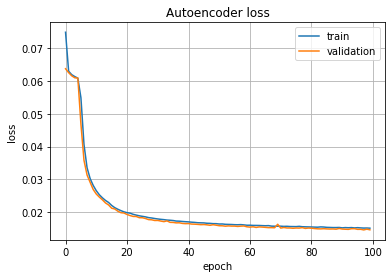

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 88, 88, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 16)        4624      
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 8)         1160      
                                                                 
 flatten_1 (Flatten)         (None, 968)               0         
                                                                 
 dense_4 (Dense)             (None, 484)               468996    
                                                      

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 484)               48884     
                                                                 
 reshape_1 (Reshape)         (None, 11, 11, 4)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 22, 22, 8)        296       
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 44, 44, 16)       1168      
 ranspose)                                                       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 88, 88, 16)      

In [ ]:
autoencoder.summary()
#autoencoder.save("saved_model")

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 100)               523600    
                                                                 
 sequential_3 (Sequential)   (None, 176, 176, 1)       65377     
                                                                 
Total params: 588,977
Trainable params: 588,977
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()

In [ ]:
decoded_imgs = autoencoder.decoder(encoded_imgs[:800]).numpy()

In [ ]:
decoded_imgs2 = autoencoder.decoder(encoded_imgs[800:]).numpy()

In [ ]:
decoded_imgs = np.vstack([decoded_imgs, decoded_imgs2])
print(decoded_imgs.shape)

(2200, 176, 176, 1)


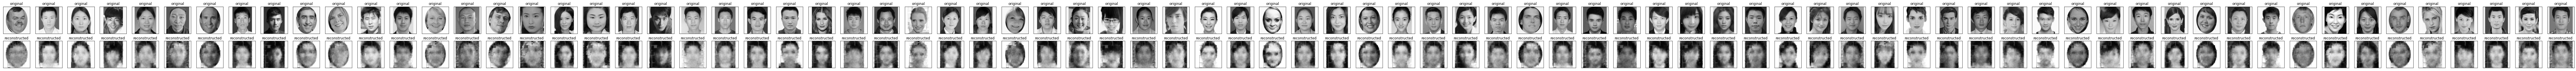

In [ ]:
n = 80
plt.figure(figsize=(160, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].reshape(176,176))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
print(type(encoded_imgs))
print(encoded_imgs.shape)

<class 'numpy.ndarray'>
(1500, 100)


In [ ]:
encoded_imgs_train = autoencoder.encoder(x_train).numpy()
encoded_imgs_test = encoded_imgs

In [ ]:
print(encoded_imgs_train.shape)
print(encoded_imgs_test.shape)

(4000, 100)
(1500, 100)


In [ ]:
import os
# reading the GT file
labels_file = pd.read_excel(os.getcwd() + "/All_Ratings.xlsx")

print(labels_file.columns)
print(labels_file.head)

Index(['Rater', 'Filename', 'Rating', 'original Rating'], dtype='object')
<bound method NDFrame.head of         Rater   Filename  Rating  original Rating
0           1    CF1.jpg       3              NaN
1           1   CF10.jpg       3              NaN
2           1  CF100.jpg       1              NaN
3           1  CF101.jpg       2              NaN
4           1  CF102.jpg       3              NaN
...       ...        ...     ...              ...
329995     60  AM995.jpg       2              NaN
329996     60  AM996.jpg       2              NaN
329997     60  AM997.jpg       3              NaN
329998     60  AM998.jpg       3              NaN
329999     60  AM999.jpg       2              NaN

[330000 rows x 4 columns]>


In [ ]:
import tqdm
# creating dictionary with grades
uniques = np.unique(labels_file["Filename"])
grades_dict = {key : [] for key in uniques}

for i in tqdm.tqdm(range(330000)):
    grades_dict[labels_file.iloc[i]["Filename"]].append(labels_file.iloc[i]["Rating"])

100%|██████████| 330000/330000 [01:03<00:00, 5164.01it/s]


{'AF1.jpg': 3, 'AF10.jpg': 4, 'AF100.jpg': 3, 'AF1000.jpg': 4, 'AF1001.jpg': 4, 'AF1002.jpg': 3, 'AF1003.jpg': 3, 'AF1004.jpg': 3, 'AF1005.jpg': 2, 'AF1006.jpg': 3, 'AF1007.jpg': 3, 'AF1008.jpg': 3, 'AF1009.jpg': 4, 'AF101.jpg': 2, 'AF1010.jpg': 3, 'AF1011.jpg': 3, 'AF1012.jpg': 3, 'AF1013.jpg': 4, 'AF1014.jpg': 4, 'AF1015.jpg': 4, 'AF1016.jpg': 4, 'AF1017.jpg': 3, 'AF1018.jpg': 3, 'AF1019.jpg': 2, 'AF102.jpg': 3, 'AF1020.jpg': 3, 'AF1021.jpg': 3, 'AF1022.jpg': 4, 'AF1023.jpg': 3, 'AF1024.jpg': 3, 'AF1025.jpg': 2, 'AF1026.jpg': 4, 'AF1027.jpg': 4, 'AF1028.jpg': 2, 'AF1029.jpg': 4, 'AF103.jpg': 3, 'AF1030.jpg': 2, 'AF1031.jpg': 4, 'AF1032.jpg': 3, 'AF1033.jpg': 2, 'AF1034.jpg': 3, 'AF1035.jpg': 3, 'AF1036.jpg': 3, 'AF1037.jpg': 2, 'AF1038.jpg': 3, 'AF1039.jpg': 4, 'AF104.jpg': 3, 'AF1040.jpg': 2, 'AF1041.jpg': 2, 'AF1042.jpg': 3, 'AF1043.jpg': 3, 'AF1044.jpg': 3, 'AF1045.jpg': 4, 'AF1046.jpg': 2, 'AF1047.jpg': 3, 'AF1048.jpg': 3, 'AF1049.jpg': 3, 'AF105.jpg': 4, 'AF1050.jpg': 3, 'AF1051

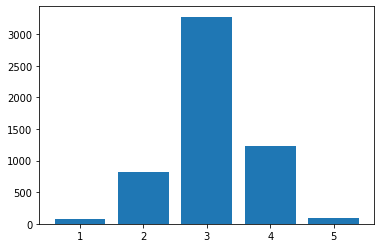

In [ ]:
# creating final grades based on most frequent values
dominant_dict = {key : np.argmax(np.bincount(grades_dict[key])) for key in grades_dict.keys()}
print(dominant_dict)

# check the distribution among classes
a, b = np.unique(list(dominant_dict.values()), return_counts=True)
plt.bar(a,b)
print(b)

In [ ]:
print(len(training_paths))

for path in training_paths:
  if 'dominant_ratings' in  os.path.split(path)[-1]:
    print(path)

4000


In [ ]:
print(training_paths)

['/content/drive/MyDrive/ArticleML/Images/AM447.jpg', '/content/drive/MyDrive/ArticleML/Images/AM689.jpg', '/content/drive/MyDrive/ArticleML/Images/CF284.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1948.jpg', '/content/drive/MyDrive/ArticleML/Images/AF869.jpg', '/content/drive/MyDrive/ArticleML/Images/AM531.jpg', '/content/drive/MyDrive/ArticleML/Images/CF132.jpg', '/content/drive/MyDrive/ArticleML/Images/CM281.jpg', '/content/drive/MyDrive/ArticleML/Images/AF434.jpg', '/content/drive/MyDrive/ArticleML/Images/AF615.jpg', '/content/drive/MyDrive/ArticleML/Images/AM1401.jpg', '/content/drive/MyDrive/ArticleML/Images/CM343.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1781.jpg', '/content/drive/MyDrive/ArticleML/Images/AF702.jpg', '/content/drive/MyDrive/ArticleML/Images/AF824.jpg', '/content/drive/MyDrive/ArticleML/Images/CM351.jpg', '/content/drive/MyDrive/ArticleML/Images/AF927.jpg', '/content/drive/MyDrive/ArticleML/Images/AF1729.jpg', '/content/drive/MyDrive/ArticleML/Images/

In [ ]:
Y_train = [dominant_dict[os.path.split(path)[-1]] for path in training_paths]
Y_test = [dominant_dict[os.path.split(path)[-1]] for path in testing_paths]

In [ ]:
def convert_normal_encode_to_one_hot(old_label):
    label = [0, 0, 0, 0, 0]
    label[old_label-1] = 1
    return label


for idx in range(len(Y_train)):
  Y_train[idx] = convert_normal_encode_to_one_hot(Y_train[idx])

for idx in range(len(Y_test)):
  Y_test[idx] = convert_normal_encode_to_one_hot(Y_test[idx])


In [ ]:
X_train = encoded_imgs_train
X_test = encoded_imgs_test

print(X_train.shape)
print(X_test.shape)

(4000, 100)
(1500, 100)


In [ ]:
# DECISION TREE ON TRAINNG DATA:

X_train1 = X_train[:3500]
Y_train1 = Y_train[:3500]

X_test1 = X_train[3500:]
Y_test1 = Y_train[3500:]

In [ ]:
Y_train1 = np.array(Y_train)
Y_test1 = np.array(Y_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
clf = clf.fit(X_train1,Y_train1)

y_pred1 = clf.predict(X_test1)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(Y_test1, y_pred1))

Accuracy: 0.55


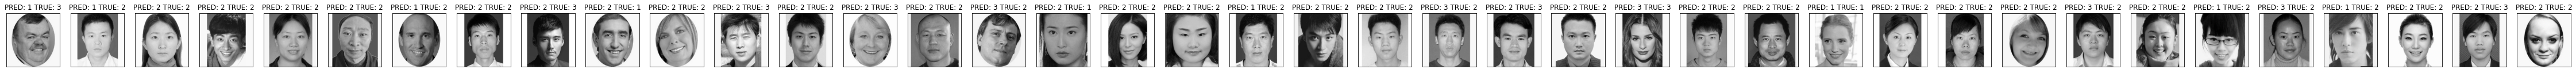

In [ ]:
n = 40
plt.figure(figsize=(80, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title(f"PRED: {list(y_pred1[i]).index(1)} TRUE: {list(Y_test1[i]).index(1)}")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

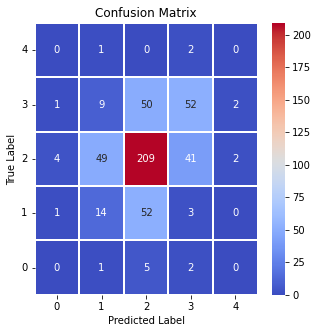

In [ ]:
import seaborn as sns

classes = [0, 1, 2, 3, 4]
# define the confusion matrix functions in order to show the results
def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=classes,
                yticklabels=classes,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)  # Don't rotate (vertically) the y-axis labels
    #hm.invert_yaxis() # Invert the labels of the y-axis
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Y_pred_label = [list(y_pred1[i]).index(1) for i in range(len(y_pred1))]
Y_test_label = [list(Y_test1[i]).index(1) for i in range(len(Y_test1))]


show_confusion_matrix(Y_pred_label, Y_test_label, 5)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(Y_test_label, Y_pred_label))
print(confusion_matrix(Y_test_label, Y_pred_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.20      0.19      0.19        74
           2       0.69      0.66      0.67       316
           3       0.46      0.52      0.49       100
           4       0.00      0.00      0.00         4

    accuracy                           0.55       500
   macro avg       0.27      0.27      0.27       500
weighted avg       0.55      0.55      0.55       500

[[  0   1   4   1   0]
 [  1  14  49   9   1]
 [  5  52 209  50   0]
 [  2   3  41  52   2]
 [  0   0   2   2   0]]


In [ ]:
# DECISION TREE ON AUTOENCODER'S TESTING DATA:

X_train2 = X_test[:1300]
Y_train2 = Y_test[:1300]

X_test2 = X_test[1300:]
Y_test2 = Y_test[1300:]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
clf = clf.fit(X_train2,Y_train2)

y_pred2 = clf.predict(X_test2)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(Y_test2, y_pred2))

Accuracy: 0.49


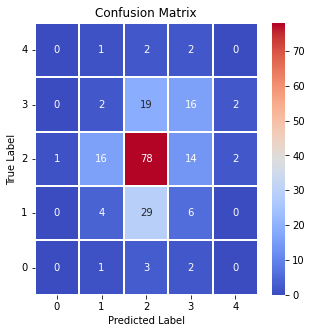

In [ ]:
import seaborn as sns


Y_pred_label2 = [list(y_pred2[i]).index(1) for i in range(len(y_pred2))]
Y_test_label2 = [list(Y_test2[i]).index(1) for i in range(len(Y_test2))]


show_confusion_matrix(Y_pred_label2, Y_test_label2, 5)

In [ ]:
print(classification_report(Y_test_label2, Y_pred_label2))
print(confusion_matrix(Y_test_label2, Y_pred_label2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.10      0.17      0.13        24
           2       0.70      0.60      0.64       131
           3       0.41      0.40      0.41        40
           4       0.00      0.00      0.00         4

    accuracy                           0.49       200
   macro avg       0.24      0.23      0.24       200
weighted avg       0.55      0.49      0.52       200

[[ 0  0  1  0  0]
 [ 1  4 16  2  1]
 [ 3 29 78 19  2]
 [ 2  6 14 16  2]
 [ 0  0  2  2  0]]
